In [25]:
import sys
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)

import sklearn
from sklearn import svm, datasets
from sklearn.utils import shuffle
from sklearn import cross_validation, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.svm import SVC
from sklearn.datasets.covtype import fetch_covtype
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from scipy import interp
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve


sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Task 1: Select what features you'll use.
labels_list = ['poi'] # You will need to use more features

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [26]:
DataFrame = pd.DataFrame()
df = DataFrame.from_dict(data_dict, orient='index', dtype=None)

df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,...,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,...,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN


In [27]:
df['poi'].value_counts()

False    128
True      18
Name: poi, dtype: int64

In [28]:
for col in df.columns:
    for i in range(len(df)):
        if df.ix[i, col] == 'NaN':
            df.ix[i, col] = np.nan
    
##played around with pandas a bit to see what the data looks like
##view everyone's salary and see if there are obvious rows to drop
df = df.fillna(value= -0.42)
df[0:20]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955.00,2902.00,2869717.00,4484442,1729541.00,4175000.00,126027.00,1407.00,-126027.00,1729541.00,...,-0.42,2195.00,152.00,65.00,False,-0.42,-3081055.00,304805.00,phillip.allen@enron.com,47.00
BADUM JAMES P,-0.42,-0.42,178980.00,182466,257817.00,-0.42,-0.42,-0.42,-0.42,257817.00,...,-0.42,-0.42,-0.42,-0.42,False,-0.42,-0.42,-0.42,-0.42,-0.42
BANNANTINE JAMES M,477.00,566.00,-0.42,916197,4046157.00,-0.42,1757552.00,465.00,-560222.00,5243487.00,...,-0.42,29.00,864523.00,0.00,False,-0.42,-5104.00,-0.42,james.bannantine@enron.com,39.00
BAXTER JOHN C,267102.00,-0.42,1295738.00,5634343,6680544.00,1200000.00,3942714.00,-0.42,-0.42,10623258.00,...,-0.42,-0.42,2660303.00,-0.42,False,-0.42,-1386055.00,1586055.00,-0.42,-0.42
BAY FRANKLIN R,239671.00,-0.42,260455.00,827696,-0.42,400000.00,145796.00,-0.42,-82782.00,63014.00,...,-0.42,-0.42,69.00,-0.42,False,-0.42,-201641.00,-0.42,frank.bay@enron.com,-0.42
BAZELIDES PHILIP J,80818.00,-0.42,684694.00,860136,1599641.00,-0.42,-0.42,-0.42,-0.42,1599641.00,...,-0.42,-0.42,874.00,-0.42,False,-0.42,-0.42,93750.00,-0.42,-0.42
BECK SALLY W,231330.00,7315.00,-0.42,969068,-0.42,700000.00,126027.00,2639.00,-0.42,126027.00,...,-0.42,4343.00,566.00,386.00,False,-0.42,-0.42,-0.42,sally.beck@enron.com,144.00
BELDEN TIMOTHY N,213999.00,7991.00,2144013.00,5501630,953136.00,5249999.00,157569.00,5521.00,-0.42,1110705.00,...,-0.42,484.00,210698.00,108.00,True,-0.42,-2334434.00,-0.42,tim.belden@enron.com,228.00
BELFER ROBERT,-0.42,-0.42,-102500.00,102500,3285.00,-0.42,-0.42,-0.42,44093.00,-44093.00,...,-0.42,-0.42,-0.42,-0.42,False,3285.00,-0.42,-0.42,-0.42,-0.42
BERBERIAN DAVID,216582.00,-0.42,-0.42,228474,1624396.00,-0.42,869220.00,-0.42,-0.42,2493616.00,...,-0.42,-0.42,-0.42,-0.42,False,-0.42,-0.42,-0.42,david.berberian@enron.com,-0.42


In [29]:
### Task 2: Remove outliers

df = df.drop('TOTAL')
df = df.drop('THE TRAVEL AGENCY IN THE PARK')
df = df.drop('email_address', axis=1)

### Task 3: Create new feature(s)

df['from_ratio'] = df.from_poi_to_this_person / df.from_messages
df['to_ratio'] = df.from_this_person_to_poi / df.to_messages
df['percent_bonus'] = df.bonus / df.total_payments
df['percent_salary'] = df.salary / df.total_payments
df['percent_restricted_stock'] = df.restricted_stock / df.total_stock_value

features_list = ['from_ratio', 'to_ratio', 'percent_bonus', 'percent_salary', 'percent_restricted_stock']

In [30]:
finance_list = ['bonus', 'exercised_stock_options', 'total_stock_value',
                 'salary', 'deferral_payments', 'total_payments',
                  'loan_advances', 'restricted_stock_deferred',
                  'deferred_income', 'expenses', 'other', 'long_term_incentive',
                'restricted_stock', 'director_fees']
administrative_list = ['to_messages', 'from_poi_to_this_person', 'from_messages',
                  'from_this_person_to_poi', 'shared_receipt_with_poi']

features_list += finance_list + administrative_list

In [31]:
features = df[features_list]
labels = df[labels_list].astype(int)

labels_train, labels_test, features_train, features_test = train_test_split(
	labels, features, test_size=0.3, random_state=42)

In [32]:
## Cindi's advice!!
# baseline decision tree with 1 feature & see what accuracy
# look at confusion matrices for training & test set
# challenge: kind of small, imbalanced. Read Tom's post. Smart guy.
# look at the training set accuracy as well. 

In [33]:
def plot_ROC_curve(classifier, X, y, pos_label=1, n_folds=5):
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for i, (train, test) in enumerate(StratifiedKFold(y, n_folds=n_folds)):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1], pos_label=1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    mean_tpr /= n_folds
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Chart')
    plt.legend(loc="lower right")
    plt.show()

In [34]:
def plot_PR_curve(classifier, X, y, n_folds=5):
    """
    Plot a basic precision/recall curve.
    """
    for i, (train, test) in enumerate(StratifiedKFold(y, n_folds = n_folds)):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        precision, recall, thresholds = precision_recall_curve(y[test], probas_[:, 1],
                                                               pos_label=1)
        plt.plot(recall, precision, lw=1, label='PR fold %d' % (i,))
   # clf_name = str(type(classifier))
   # clf_name = clf_name[clf_name.rindex('.')+1:]
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-recall curve')
    plt.legend(loc="lower right")
    plt.show()

             precision    recall  f1-score   support

          0       0.95      1.00      0.97        39
          1       1.00      0.60      0.75         5

avg / total       0.96      0.95      0.95        44

[[39  0]
 [ 2  3]]
{'dt__criterion': 'entropy', 'kbest__k': 3, 'dt__min_samples_leaf': 2}


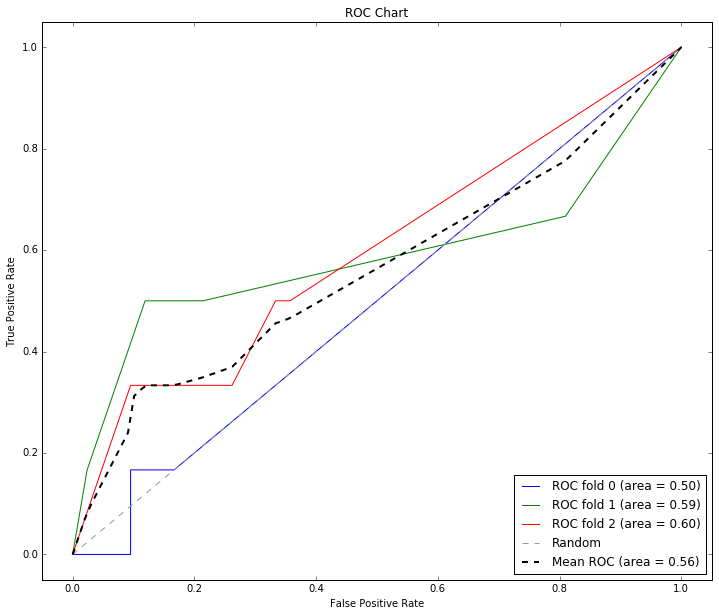

None


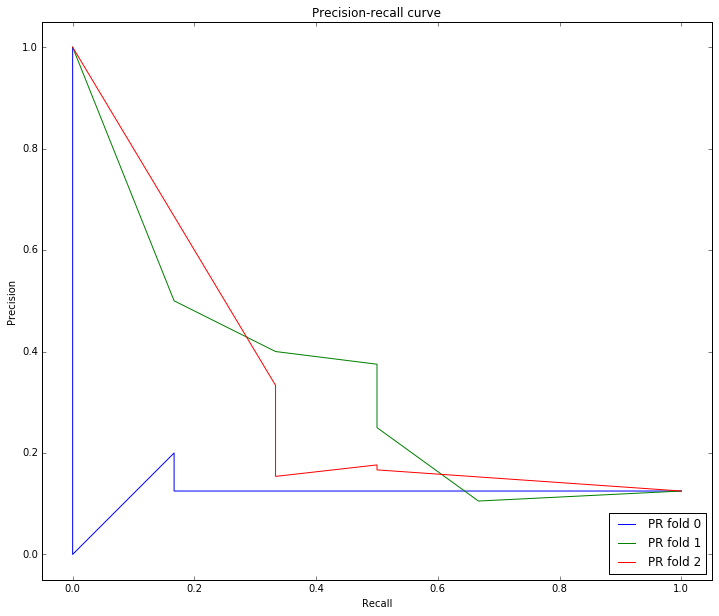

None


In [35]:
# Decision Tree Analysis
from sklearn.tree import DecisionTreeClassifier

kbest = SelectKBest(f_classif)
pipeline = Pipeline([('kbest', kbest), ('dt', DecisionTreeClassifier())])
grid_search_dt = GridSearchCV(pipeline, {'kbest__k': [1,2,3,4], 'dt__criterion': ['gini', 'entropy', 'gini', 'entropy'], 
                                      'dt__min_samples_leaf': [2, 5, 10, 15] })

grid_search_dt.fit(features.values, labels['poi'].values)
labels_pred_dt = grid_search_dt.predict(features_test)

print classification_report(labels_test, labels_pred_dt)
print confusion_matrix(labels_test, labels_pred_dt)
print grid_search_dt.best_params_ 
print plot_ROC_curve(grid_search_dt, features.values, labels['poi'].values, n_folds = 3)
print plot_PR_curve(grid_search_dt, features.values, labels['poi'].values, n_folds = 3)

             precision    recall  f1-score   support

          0       0.95      0.95      0.95        39
          1       0.60      0.60      0.60         5

avg / total       0.91      0.91      0.91        44

[[37  2]
 [ 2  3]]
{'rf__min_samples_split': 10, 'kbest__k': 2, 'rf__criterion': 'entropy'}


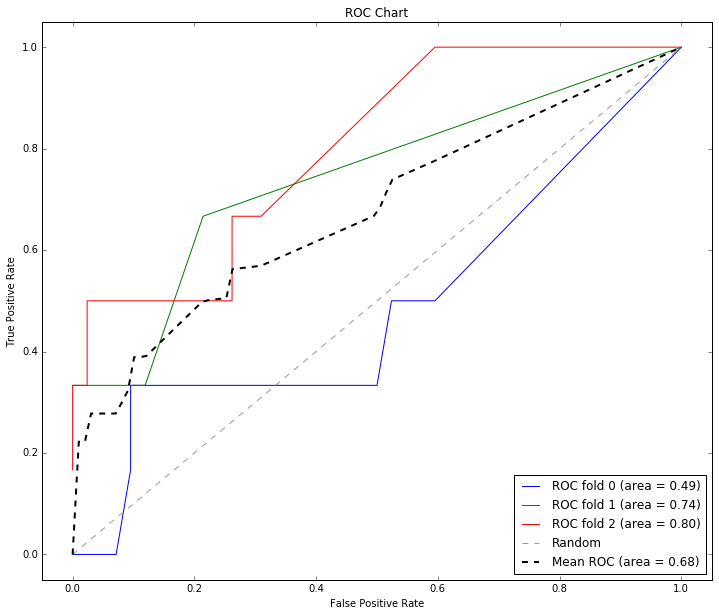

None


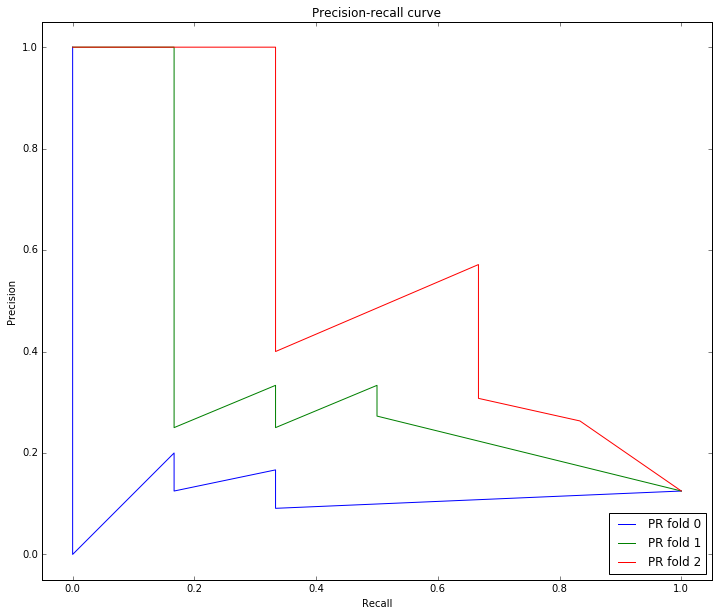

None


In [36]:
# Random Forest Analysis
from sklearn.ensemble import RandomForestClassifier

kbest = SelectKBest(f_classif)
pipeline = Pipeline([('kbest', kbest), ('rf', RandomForestClassifier())])
grid_search_rf = GridSearchCV(pipeline, {'kbest__k': [1,2,3,4], 'rf__criterion': ['gini', 'entropy', 'gini', 'entropy'], 
                                      'rf__min_samples_split': [2, 5, 10, 15] })

grid_search_rf.fit(features.values, labels['poi'].values)
labels_pred_rf = grid_search_rf.predict(features_test)

print classification_report(labels_test, labels_pred_rf)
print confusion_matrix(labels_test, labels_pred_rf)
print grid_search_rf.best_params_ 
print plot_ROC_curve(grid_search_rf, features.values, labels['poi'].values, n_folds = 3)
print plot_PR_curve(grid_search_rf, features.values, labels['poi'].values, n_folds = 3)

             precision    recall  f1-score   support

          0       0.90      0.97      0.94        39
          1       0.50      0.20      0.29         5

avg / total       0.86      0.89      0.86        44

[[38  1]
 [ 4  1]]
{'kbest__k': 1}


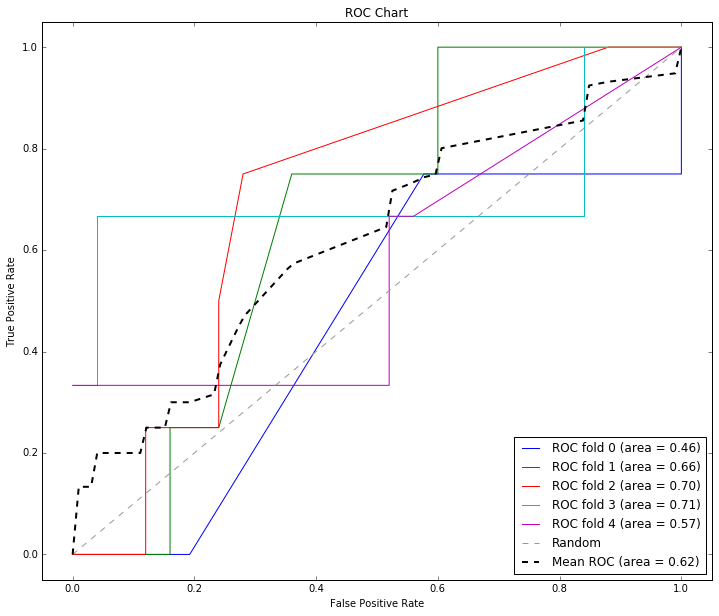

None


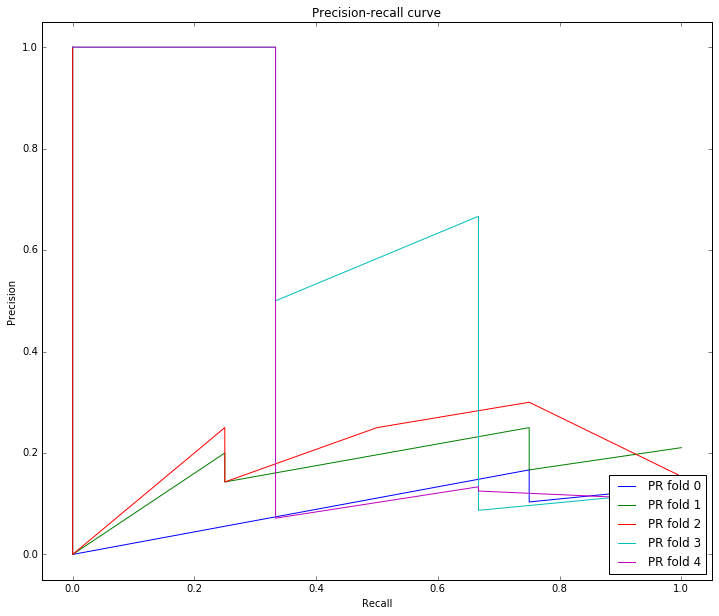

None


In [ ]:
# Gaussian NB Analysis
from sklearn.naive_bayes import GaussianNB

kbest = SelectKBest(f_classif)
pipeline = Pipeline([('kbest', kbest), ('gnb', GaussianNB())])
grid_search_gnb = GridSearchCV(pipeline, {'kbest__k': [1,2,3,4] })

grid_search_gnb.fit(features.values, labels['poi'].values)
labels_pred_gnb = grid_search_gnb.predict(features_test)

print classification_report(labels_test, labels_pred_gnb)
print confusion_matrix(labels_test, labels_pred_gnb)
print grid_search_gnb.best_params_ 
print plot_ROC_curve(grid_search_gnb, features.values, labels['poi'].values)
print plot_PR_curve(grid_search_gnb, features.values, labels['poi'].values)

In [ ]:
# SVM Analysis
from sklearn.svm import SVC

kbest = SelectKBest(f_classif)
pipeline = Pipeline([('kbest', kbest), ('svm', SVC())])
grid_search_svm = GridSearchCV(pipeline, {'kbest__k': [1,2,3,4], 'svm__C': [1, 2, 3, 4], 
                                      'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'] })

grid_search_svm.fit(features.values, labels['poi'].values)
labels_pred_svm = grid_search_svm.predict(features_test)

print classification_report(labels_test, labels_pred_svm)
print confusion_matrix(labels_test, labels_pred_svm)
print grid_search_svm.best_params_ 
print plot_ROC_curve(grid_search_svm, features.values, labels['poi'].values)
print plot_PR_curve(grid_search_svm, features.values, labels['poi'].values)

In [ ]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.


pickle.dump(clf, open("../data/my_classifier.pkl", "w"))
pickle.dump(my_dataset, open("../data/my_dataset.pkl", "w"))
pickle.dump(my_feature_list, open("../data/my_feature_list.pkl", "w"))